In [0]:
# # Uploading file on google colab from drive

# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# dff = drive.CreateFile({'id': '1xOmwNIpffdvEOrV3XYYWSN4janwjhz2J'})
# dff.GetContentFile('fer2013.csv')

In [0]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [4]:
# Adding data to dataframe

df = pd.read_csv('fer2013.csv',na_filter = False)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


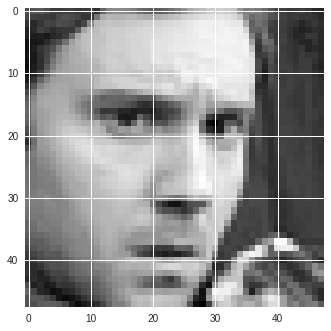

In [5]:
# Printing 1st image

img = df.pixels
face_list = img[0].split()
face = np.reshape(face_list,(48,48))
face = face.astype(int)
plt.imshow(face,cmap = 'gray')

In [0]:
# Splitting data into features and labels

def getData(filname):
    Y = []
    X = []
    first = True
    for line in open(filname):
        # dropping first row(heading)
        if first:
            first = False
        else:
            row = line.split(',')
            Y.append(int(row[0])) # Appending labels 
            X.append([int(p) for p in row[1].split()]) # Appending image pixels data

    X, Y = np.array(X) / 255.0, np.array(Y)
    return X, Y

In [7]:
X, Y = getData('fer2013.csv') #Calling getData function created above
num_class = len(set(Y))
print(num_class) # Number of unique labels

7


In [8]:
print(X.shape)
print(Y.shape)

(35887, 2304)
(35887,)


In [0]:
N, D = X.shape
X = X.reshape(N, 1, 48, 48)

In [0]:
# Splitting data for training and testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=0)
y_train = (np.arange(num_class) == y_train[:, None]).astype(np.float32)
y_test = (np.arange(num_class) == y_test[:, None]).astype(np.float32)

In [0]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1) #Reduces learning rate when accuracy stops increasing

In [0]:
# swish activation function

def swish_activation(x):
    return (K.sigmoid(x) * x)

In [14]:
def my_model():

  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,48,48)))
  model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
  model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
  model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
  model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(64, activation=swish_activation))
  model.add(Dropout(0.4))
  model.add(Dense(7 , activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer='adam' ,
                metrics=['accuracy'])
  
  return model

model = my_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 48, 48)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 48, 48)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 24, 24)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 24, 24)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 12, 12)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 96, 12, 12)        55392     
__________

In [15]:
K.tensorflow_backend.clear_session() # destroys the current graph and builds a new one
model=my_model()
K.set_value(model.optimizer.lr,1e-3)

h=model.fit(x=X_train,     
            y=y_train, 
            batch_size=64, 
            epochs=15, 
            verbose=1, 
            validation_data=(X_test,y_test),
            shuffle=True,
            callbacks=[lr_reduce],
           )
model.save_weights("model.h5") # Saving weights of trained neural networks in 'model.h5' file

Train on 34092 samples, validate on 1795 samples
Epoch 1/15
34092/34092 [==============================] - 25s 727us/step - loss: 0.4029 - acc: 0.8552 - val_loss: 0.3883 - val_acc: 0.8571
Epoch 2/15
34092/34092 [==============================] - 23s 675us/step - loss: 0.3885 - acc: 0.8573 - val_loss: 0.3630 - val_acc: 0.8608
Epoch 3/15
34092/34092 [==============================] - 23s 674us/step - loss: 0.3402 - acc: 0.8703 - val_loss: 0.3000 - val_acc: 0.8835
Epoch 4/15
34092/34092 [==============================] - 23s 675us/step - loss: 0.2991 - acc: 0.8820 - val_loss: 0.2751 - val_acc: 0.8891
Epoch 5/15
34092/34092 [==============================] - 23s 676us/step - loss: 0.2758 - acc: 0.8892 - val_loss: 0.2575 - val_acc: 0.8978
Epoch 6/15
34092/34092 [==============================] - 23s 676us/step - loss: 0.2566 - acc: 0.8955 - val_loss: 0.2561 - val_acc: 0.8967

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/15
34092/34092 [===========

In [0]:
# Saving model in 'model.json' file

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

(1, 1, 48, 48)


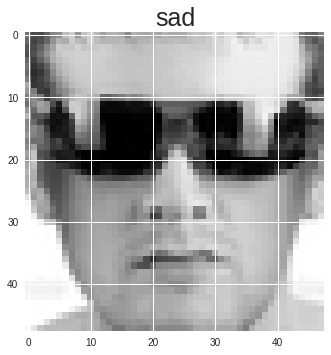

In [17]:
objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral') # Types of Labels

# Preparing input for getting prediction
y = img[9999].split()
y = np.reshape(y,(1,1,48,48))
print(y.shape)
y = y.astype(int)
x = y/255

# Predicting output
custom = model.predict(x)

x = x.reshape([48, 48]); # Reshaping image to print

plt.imshow(x, cmap = 'gray')
plt.title(objects[np.argmax(custom)],fontsize=25) # Printing predicted emotion in image title
plt.show()

In [0]:
# Downloading model and saved weights

from google.colab import files
files.download('model.json')
files.download('model.h5')